In [1]:
#Import libraries
import google_streetview.api
import google_streetview.helpers
from geoalchemy2 import Geometry, WKTElement
from sqlalchemy import *
import time
import psycopg2
from shapely.geometry import *
#shapely.speedups.enable()
import subprocess
import sys,os,os.path
import pandas as pd
import geopandas as gpd 
import requests
import pandas as pd
import zipfile
import io
import shapely
import numpy as np
import psycopg2
import networkx as nx
import multiprocessing as mp
import pandana as pdna
import h5py
import shapefile
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from shapely import ops
from shapely import wkt
from shapely.geometry import Polygon, LineString, Point, box
from geoalchemy2 import Geometry, WKTElement
from sqlalchemy import *
from shapely.geometry import *
from fiona.crs import from_epsg
from mpl_toolkits.axes_grid1 import make_axes_locatable
import urllib.request, urllib.parse, urllib.error,urllib.request,urllib.error,urllib.parse
import xmltodict
from io import StringIO
import ogr, osr
from urllib.request import urlopen
import xmltodict
import fiona
from shapely.geometry import shape,mapping
from shapely.ops import transform
from functools import partial
import pyproj
from fiona.crs import from_epsg
import time
from PIL import Image
import itertools
%matplotlib inline

pd.options.display.max_rows = 120

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

/opt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# set proxies if work behind proxy
import sys,os,os.path




In [3]:
# download centerline data from https://open.toronto.ca/catalogue/
url = 'https://ckan0.cf.opendata.inter.prod-toronto.ca/download_resource/3a00bc1b-1c2d-40b5-b377-720b6d1b9b13'
local_path = 'tmp/'
print('Downloading zipped shapefile...')
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
print("Done")
z.extractall(path=local_path) # extract to folder
filenames = [y for y in sorted(z.namelist()) for ending in ['dbf', 'prj', 'shp', 'shx'] if y.endswith(ending)] 
print(filenames)

Done
['CENTRELINE_WGS84.dbf', 'CENTRELINE_WGS84.prj', 'CENTRELINE_WGS84.shp', 'CENTRELINE_WGS84.shx']


In [ ]:
#centreline = gpd.read_file("zip:///home/asulaim/toronto-centreline-wgs84-latitude-longitude.zip")
centreline = gpd.read_file("tmp/CENTRELINE_WGS84.shp")

In [ ]:
from shapely.geometry import Point, LineString, shape
import fiona
# open a line shapefile
file = fiona.open('tmp/CENTRELINE_WGS84.shp')
centreline.crs

In [ ]:
centreline.tail(2)

In [ ]:

# download intersections data from https://open.toronto.ca/catalogue/
url = 'https://ckan0.cf.opendata.inter.prod-toronto.ca/download_resource/1d84f2f9-f551-477e-a7fa-f92caf2ae28d'
local_path = 'tmp/'
print('Downloading zipped shapefile...')
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
print("Done")
z.extractall(path=local_path) # extract to folder
filenames = [y for y in sorted(z.namelist()) for ending in ['dbf', 'prj', 'shp', 'shx'] if y.endswith(ending)] 
print(filenames)


In [ ]:
#centreline = gpd.read_file("zip:///home/asulaim/toronto-centreline-wgs84-latitude-longitude.zip")
intersections = gpd.read_file("tmp/CENTRELINE_INTERSECTION_WGS84.shp")

In [ ]:
intersections.head(1)

In [77]:
# Creating points based on 200m distance if centerline road segments loger than 600m. points id will be 1,2,3,4 based on the number of division
#Otherwise, just get centerline midpoints. For example 200m distance based on centreline shapefile. Points id is defined as 99.
# the input shapefile has to be in projection of WGS84, 4326

geo_id_list =[]
fcode_list = []
def createPoints(inshp, outshp):
    count = 0
    
    s = {'GEO_ID' 'LFN_ID' 'LF_NAME' 'ADDRESS_L' 'ADDRESS_R' 'OE_FLAG_L'  'OE_FLAG_R' 'LONUML' 'HINUML' 'LONUMR' 'HINUMR' 'FNODE' 'TNODE' 'FCODE'
 'FCODE_DESC' 'JURIS_CODE' 'OBJECTID' 'geometry'}
    # the temporaray file of the cleaned data
    root = os.path.dirname(inshp)
    basename = 'clean_' + os.path.basename(inshp)
    temp_cleanedfile = os.path.join(root,basename)
    
    # if the tempfile exist then delete it
    if os.path.exists(temp_cleanedfile):
        fiona.remove(temp_cleanedfile, 'ESRI Shapefile')
    
   
    with fiona.open(inshp) as source, fiona.open(temp_cleanedfile, 'w', driver=source.driver, crs=source.crs,schema=source.schema) as dest:
        
        for feat in source:
            try:
                i = feat['properties']['GEO_ID'] # for the street data
                if i in s:
                    continue
            except:
                key = dest.schema['properties'].keys()[0] # get the field of the input shapefile and duplicate the input feature
                i = feat['properties'][key]
                if i in s:
                    continue            
            dest.write(feat)
    schema = {
        'geometry': 'Point',
        'properties': {'id': 'int'},        
    }

    # Create points along the segments
    with fiona.drivers():
        #with fiona.open(outshp, 'w', 'ESRI Shapefile', crs=source.crs, schema) as output:
        with fiona.open(outshp, 'w', crs = from_epsg(4326), driver = 'ESRI Shapefile', schema = schema) as output:
            

            for line in fiona.open(temp_cleanedfile):
                
                first = shape(line['geometry'])
                length = first.length
                #print(length)

                # convert degree to meter, in order to split by distance in meter
                project = partial(pyproj.transform,pyproj.Proj(init='EPSG:4326'),pyproj.Proj(init='EPSG:3857')) #3857 is psudo WGS84 the unit is meter

                line2 = transform(project, first)
                linestr = list(line2.coords)

                if line2.length>= 600:
                    cont=0
                    dist = mini_dist #set
                    for distance in range(0,int(line2.length), dist):
                        cont +=1
                        point = line2.interpolate(distance)
                        #print(cont)
                        # attributes
                        geo_id = line['properties']['GEO_ID']
                        fcode_desc =  line['properties']['FCODE_DESC']                        
                        geo_id_list.append(geo_id)
                        fcode_list.append(fcode_desc)
                        # convert the local projection back the the WGS84 and write to the output shp
                        project2 = partial(pyproj.transform,pyproj.Proj(init='EPSG:3857'),pyproj.Proj(init='EPSG:4326'))
                        point = transform(project2, point)
                        output.write({
                            'properties': {
                                'id':cont,                                
                            },                            
                            'geometry': mapping(point)
                        })
                        
                else:
                    mdist = int(line2.length/2)
                    #print(mdist)
                    geo_id =  line['properties']['GEO_ID']
                    fcode_desc =  line['properties']['FCODE_DESC']
                    geo_id_list.append(geo_id)
                    fcode_list.append(fcode_desc)
                    #for distanc in range(0,int(line2.length), mdist):

                    point = line2.interpolate(mdist)

                    # convert the local projection back the the WGS84 and write to the output shp
                    project3 = partial(pyproj.transform,pyproj.Proj(init='EPSG:3857'),pyproj.Proj(init='EPSG:4326'))
                    point = transform(project3, point)
                    #prop = {'id': 99,'GEO_ID': int(GEO_ID)}
                    #output.write({'geometry':mapping(point),'GEO_ID':GEO_ID,'properties': {'id':99}})
                    output.write({
                        'properties': {
                            'id':99,                          
                        },                        
                        'geometry': mapping(point)
                    })
                

            df = pd.DataFrame(geo_id_list)
    print("Process Complete")
    
    # delete the temprary cleaned shapefile
    fiona.remove(temp_cleanedfile, 'ESRI Shapefile')

temp_path = 'tmp/'
outputpath = '/home/asulaim/data'
inshp = os.path.join(temp_path,'CENTRELINE_WGS84.shp')
outshp = os.path.join(temp_path,'splitpnts.shp')
max_dis = 600
mini_dist = 200 #the minimum distance between two generated points in meter
createPoints(inshp, outshp)
df1= pd.DataFrame(geo_id_list)
df1.columns = [
    'geoid'
    ]
#df
df2 = pd.DataFrame(fcode_list)
df2.columns = [
    'fcode'
]
df3 = pd.concat([df1, df2.reindex(df1.index)], axis=1)
t200m = gpd.read_file('tmp/splitpnts.shp')
df = pd.DataFrame(t200m)
t200m = pd.merge(left=df, left_index=True , right=df3, right_index=True, how='inner')
t200m['geometry'] = t200m['geometry'].apply(Point)
crs = {'init': 'epsg:4326'}
t200m = gpd.GeoDataFrame(t200m, crs=crs, geometry='geometry')
t200m["lon"]=t200m.geometry.x
t200m["lat"]=t200m.geometry.y

t200m.to_csv("/media/DATADRIVE/Toronto_Streetscore/toronto/splitpoints_images/t200m.csv")
t200m.head(5)
    


Process Complete


,id,geometry,geoid,fcode,lon,lat
0,1,POINT (-79.54477895299999 43.58582901999998),30079678,Trail,-79.544779,43.585829
1,2,POINT (-79.54356556422695 43.58491109437305),30079678,Trail,-79.543566,43.584911
2,3,POINT (-79.54359896795523 43.58364405778823),30079678,Trail,-79.543599,43.583644
3,4,POINT (-79.54394682496371 43.58239162434106),30079678,Trail,-79.543947,43.582392
4,99,POINT (-79.54498541880002 43.58587174655035),30079680,Trail,-79.544985,43.585872


In [78]:
t200m.fcode.unique()

array(['Trail', 'Other', 'River', 'Local', 'Major Arterial', 'Laneway',
       'Major Railway', 'Major Shoreline', 'Geostatistical line',
       'Collector', 'Walkway', 'Hydro Line', 'Minor Arterial',
       'Expressway', 'Expressway Ramp', 'Pending', 'Major Arterial Ramp',
       'Access Road', 'Minor Shoreline (Land locked)', 'Ferry Route',
       'Busway', 'Collector Ramp', 'Creek/Tributary', 'Other Ramp',
       'Minor Railway', 'Minor Arterial Ramp'], dtype=object)

Text(0.2,0.12,'Source: Toronto Open Data')

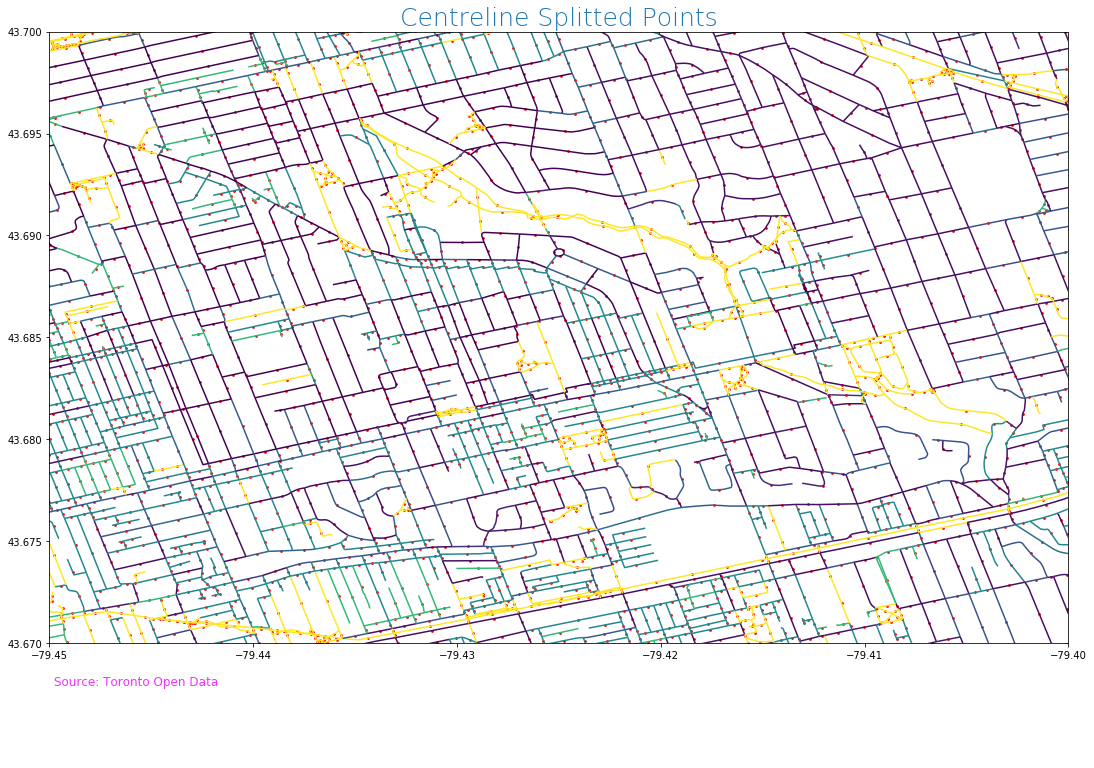

In [79]:
# ploting created points along centerline
ax = centreline.plot(figsize=(15, 15), column='GEO_ID', legend=False)
t200m.plot(ax=ax, color='red', markersize =3)
plt.title('Centreline Splitted Points')
plt.tight_layout()
ax.set(xlim=(-79.450, -79.400), ylim=(43.67, 43.70))

# add a title
ax.set_title('Centreline Splitted Points', fontdict={'fontsize': '25', 'fontweight' : '4'}, color='C0')
# create an annotation for the data source
ax.annotate('Source: Toronto Open Data',xy=(0.2, .12),  xycoords='figure fraction', horizontalalignment='right', verticalalignment='top', fontsize=12, color='#F033FF')

#fig.savefig("./t200m.png", dpi=300)

In [ ]:
# Downloaded GSV imageS 
point = pd.read_csv('/media/DATADRIVE/Toronto_Streetscore/toronto/splitpoints_images/t200m.csv')
point['gid'] = point.index
point['lat_trim'] = point.lat.astype(str).str.slice(0,7)
point['long_trim'] = point.lon.astype(str).str.slice(0,8)
point['location'] = point.lat_trim.astype(str).str.cat(point.long_trim.astype(str), sep=',')
# point
point['image'] =None
point['image_0'] =None
point['image_90'] =None
point['image_180'] =None
point['image_270'] =None
# point['image_0_url'] =None
# point['image_90_url'] =None
# point['image_180_url'] =None
# point['image_270_url'] =None
#ftp://asulaim@172.19.118.205/media/DATADRIVE/Toronto_Streetscore/toronto/splitpoints_images
point.tail(5)

In [ ]:
import urllib.request
import shutil
import tempfile
import urllib.request
import urllib.parse
import os
key = "&key="+"" #got banned after ~100 requests with no key

def GetStreet(i,Id,location,heading=None):
    i=i
    if heading:
        base = "https://maps.googleapis.com/maps/api/streetview?size=640x640&heading="+str(heading)+"&source=outdoor&fov=120&location="
    else:
        base = "https://maps.googleapis.com/maps/api/streetview?size=640x640&source=outdoor&fov=120&radius=50&location="

    MyUrl = base + urllib.parse.quote_plus(location) + key #added url encoding
    
    fi = r"/media/DATADRIVE/Toronto_Streetscore/toronto/splitpoints_images/"+str(i)+"_"+str(heading)+".jpg"
   # point['image_180_url']= MyUrl
    point['heading']= str(i)+"_"+str(heading)+".jpg"
    if not os.path.isfile(fi):
        try:
            #print(MyUrl)
            with requests.get(MyUrl, stream=True) as response:
                data = response.raw.read()

                if int(response.headers['content-length']) >100:
                    print(fi)                
                    print(MyUrl)
                    
                    output = open(fi,"wb")
                    output.write(data)
                    output.close()
                else:
                    fi = None
        except:
            fi = "Failed"
            pass
    return fi 

In [ ]:
c = 0

for i, row in point.iterrows():
    fi = GetStreet(i,row.gid,row.location,90)
    point.loc[i,'image_0'] = fi
    fi = GetStreet(i,row.gid, row.location,0)
    point.loc[i,'image_90'] = fi
    fi = GetStreet(i,row.gid, row.location,180)
    point.loc[i,'image_180'] = fi
    fi = GetStreet(i,row.gid, row.location,270)
    point.loc[i,'image_270'] = fi
    c+=1
    print(c-point.id.count())
    if c >= 250000:
        break